In [305]:
#XAI
import shap
import shapflow
from shapflow.flow import Node, CreditFlow, Graph, GraphExplainer, sample_graph, eval_graph, CausalLinks, translator, create_linear_f, node_dict2str_dict
from shapflow.on_manifold import OnManifoldExplainer, IndExplainer, FeatureAttribution

# Data wrangling
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
import numpy as np



In [330]:
## Build a faux model for the data
## This will only work for ShapSampling and ShapKernel, or ShapPermutation

class faux_model:
  def __init__(self):
      self.name = 'FauxModel'

  @staticmethod
  def predict(x):
    if str(type(x)).__contains__('pandas'):
      x = x.to_numpy()

    return x[:,0:3].prod(axis = 1)

  def predict_proba(self, x):
    yhat = self.predict(x)
    return np.array([np.where(yhat == 0, 1, 0),yhat]).T


# y = data['3_vars_corr_2HC_n10000.csv']['y_test']
# x = data['3_vars_corr_2HC_n10000.csv']['X_test']

In [307]:
data_path = '/Users/eddie/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Research/Projects/Explainability Method Comparison/Data-ML-XAI-Eval/Synthetic Data/Data Files without Hidden Confounders/3_vars_corr_2HC_n100.csv'
df = pd.read_csv(data_path)

# df.columns = ['Feature 1', 'Feature 2', 'Feature 3', 'Noise', 'Target']
train, test = train_test_split(df, test_size=0.25, random_state=42)
data = {
    'X_train': train.drop('Target', axis=1),
    'y_train': train.Target,
    'X_test': test.drop('Target', axis=1),
    'y_test': test.Target
}

print(data['X_test'].columns)

Index(['HC1', 'HC2', 'C1', 'C2', 'C3', 'Noise'], dtype='object')


[0.         0.         0.1693037  0.2621037  0.09694815 0.        ]


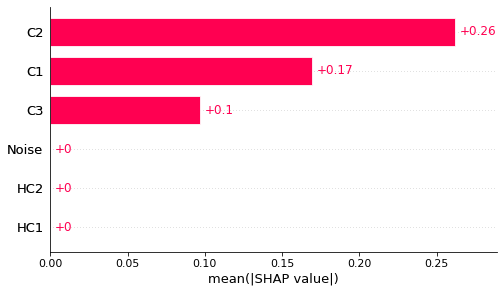

In [303]:
explainer = shap.explainers.Permutation(faux_model().predict, data['X_train'])
values = explainer(data['X_test'])

print(np.mean(np.abs(values.values), axis = 0))

shap.plots.bar(values)

# shap.waterfall_plot(values[100])

learning dependency for C2:   0%|          | 0/3 [00:00<?, ?it/s]

[0]	test-rmse:0.49952
[100]	test-rmse:0.45867


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[200]	test-rmse:0.42760
[300]	test-rmse:0.40326
[400]	test-rmse:0.38561
[499]	test-rmse:0.37157


learning dependency for C3:  33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]

[0]	test-rmse:0.49915


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[100]	test-rmse:0.42138
[200]	test-rmse:0.35568
[300]	test-rmse:0.30087
[400]	test-rmse:0.25560
[499]	test-rmse:0.21814


learning dependency for C1:  67%|██████▋   | 2/3 [00:01<00:00,  1.24it/s]

[0]	test-rmse:0.49949
[100]	test-rmse:0.45088


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[200]	test-rmse:0.41335
[300]	test-rmse:0.38664
[400]	test-rmse:0.36757
[499]	test-rmse:0.35434


learning dependency for C1: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


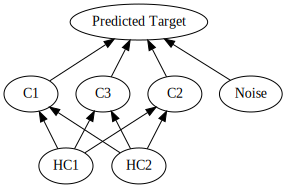

In [349]:
from shapflow.flow import build_feature_graph
causal_links = CausalLinks()
categorical_feature_names = list([])
display_translator = translator(data['X_train'].columns, data['X_train'], data['X_train'])
target_name = 'Predicted Target'
feature_names = list(['C1', 'C2', 'C3', 'Noise'])

def create_f(parents, m, **kwargs):
    '''
    assume m is a linear regression model from sklearn predict / predict_proba
    parents are list of feature names
    kwargs: keyword args that applies to the predict function
    '''
    def f_(*args):
        return m(np.vstack(args).T)

    return f_

# def predictor(x):
#     print(x)
#     x = x[['C1', 'C2', 'C3', 'Noise']]
#     return faux_model().predict(x)

causal_links.add_causes_effects(feature_names, target_name, create_f(feature_names, faux_model.predict) )
hidden_causes = ['HC1', 'HC2']
effects = ['C1', 'C2', 'C3']
causal_links.add_causes_effects(hidden_causes, effects)



graph = build_feature_graph(data['X_train'], causal_links, categorical_feature_names, display_translator, target_name)
graph.draw()

In [380]:
bg = pd.DataFrame(data['X_train'].mean(axis = 0)).T
np.max(bg.shape)

6

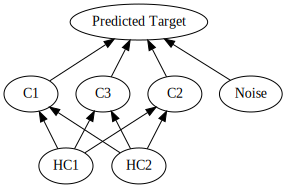

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
bruteforce sampling: 100%|██████████| 10/10 [00:00<00:00, 64.64it/s]


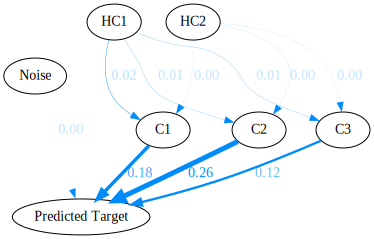

array([0.17515739, 0.25638463, 0.11815661, 0.        ])

In [374]:
# View graphviz graph
graph.draw()
def explainer(bg, graph = graph, fg = data['X_test'], **kwargs):
    explanations = GraphExplainer(graph, pd.DataFrame(bg).T, **kwargs).shap_values(fg)
    shap_values = pd.DataFrame(node_dict2str_dict(explanations.edge_credit)).applymap(lambda x: np.mean(np.abs(x)))
    shap_values = shap_values.sort_index(axis = 1)
    print(shap_values)
    return shap_values.Predicted_Target

# values = data['X_train'].apply(explainer, axis = 1, nruns = 1)
# values

explanations = GraphExplainer(graph, bg, nruns=1000).shap_values(data['X_test'])
explanations.draw()
shap_values = pd.DataFrame(node_dict2str_dict(explanations.edge_credit)).applymap(lambda x: np.mean(np.abs(x)))
shap_values = shap_values.sort_index(axis = 1)[['C1', 'C2', 'C3', 'Noise']].iloc[0].to_numpy()
shap_values
 

In [329]:
ground = pd.read_csv('/Users/eddie/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Research/Projects/Explainability Method Comparison/Data-ML-XAI-Eval/Synthetic Data/GroundTruth.csv')
ground = ground.set_index('Unnamed: 0')
ground['3_vars_corr_2HC_n100.csv'].round(2)

Unnamed: 0
C1       0.69
C2       0.83
C3       0.55
Noise    0.19
Name: 3_vars_corr_2HC_n100.csv, dtype: float64